RNN
Epoch [1/10], Train Loss: 0.8656, Train Accuracy: 71.17%, Val Loss: 0.4921, Val Accuracy: 84.63%
Epoch [2/10], Train Loss: 0.3786, Train Accuracy: 88.87%, Val Loss: 0.2727, Val Accuracy: 92.40%
Epoch [3/10], Train Loss: 0.2599, Train Accuracy: 92.64%, Val Loss: 0.2112, Val Accuracy: 93.92%
Epoch [4/10], Train Loss: 0.2124, Train Accuracy: 94.12%, Val Loss: 0.1849, Val Accuracy: 94.81%
Epoch [5/10], Train Loss: 0.1963, Train Accuracy: 94.54%, Val Loss: 0.1845, Val Accuracy: 94.76%
Epoch [6/10], Train Loss: 0.1696, Train Accuracy: 95.27%, Val Loss: 0.1668, Val Accuracy: 95.38%
Epoch [7/10], Train Loss: 0.1556, Train Accuracy: 95.70%, Val Loss: 0.1930, Val Accuracy: 94.50%
Epoch [8/10], Train Loss: 0.1529, Train Accuracy: 95.73%, Val Loss: 0.1538, Val Accuracy: 95.74%
Epoch [9/10], Train Loss: 0.1455, Train Accuracy: 95.98%, Val Loss: 0.1445, Val Accuracy: 96.11%
Epoch [10/10], Train Loss: 0.1377, Train Accuracy: 96.07%, Val Loss: 0.1445, Val Accuracy: 96.12%
LSTM
Epoch [1/10], Train 

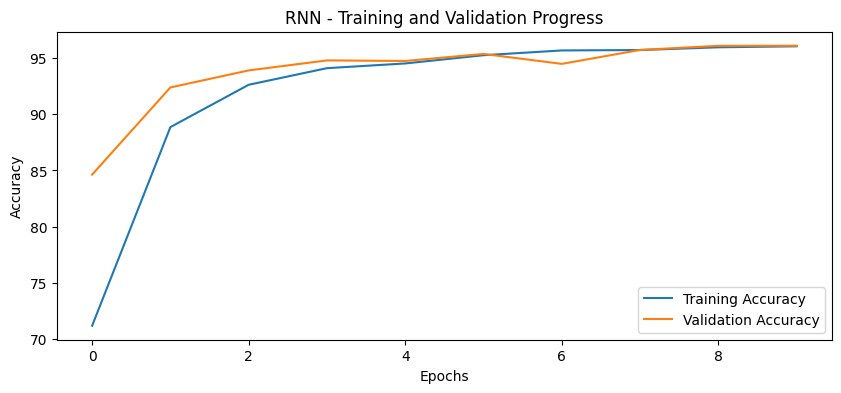

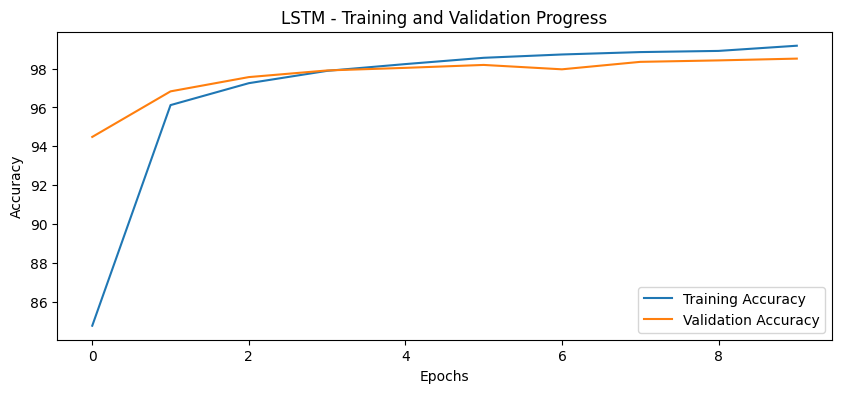

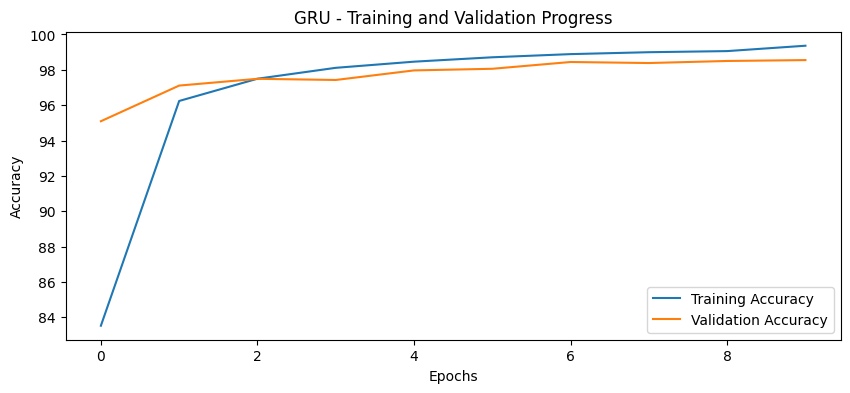

RNN Test Average Accuracy: 96.01%
LSTM Test Average Accuracy: 98.60%
GRU Test Average Accuracy: 98.45%


In [53]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# Hyperparameters
input_size = 28
hidden_size = 128
num_layers = 1
num_classes = 10
cell_types = ['RNN', 'LSTM', 'GRU']
num_epochs = 10
learning_rate = 0.001
batch_size = 64

# Load and preprocess the MNIST dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('./data', train=False, download=True, transform=transform)

# Split the training dataset into training and validation sets
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define the RNN model architecture
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, cell_type='RNN'):
        super(RNNModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        if cell_type == 'RNN':
            self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        elif cell_type == 'LSTM':
            self.rnn = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        elif cell_type == 'GRU':
            self.rnn = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        #h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        out, _ = self.rnn(x, None)
        out = self.fc(out[:, -1, :])
        return out

# Training function with validation
def train(model, train_loader, val_loader, criterion, optimizer, num_epochs):
    history = {'train_accuracy': [], 'train_loss': [], 'val_accuracy': [], 'val_loss': []}

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images = images.view(-1, input_size, input_size).to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_accuracy = 100 * correct / total
        train_loss = total_loss / len(train_loader)
        history['train_accuracy'].append(train_accuracy)
        history['train_loss'].append(train_loss)

        model.eval()
        val_loss = 0
        correct = 0
        total = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images = images.view(-1, input_size, input_size).to(device)
                labels = labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_accuracy = 100 * correct / total
        val_loss /= len(val_loader)
        history['val_accuracy'].append(val_accuracy)
        history['val_loss'].append(val_loss)

        print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')

    return history

# Evaluate function
def evaluate(model, test_loader):
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            images = images.view(-1, input_size, input_size).to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

# Create models and train

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_results = {}

for cell_type in cell_types:
    print(cell_type)
    model = RNNModel(input_size, hidden_size, num_layers, num_classes, cell_type).to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()
    history = train(model, train_loader, val_loader, criterion, optimizer, num_epochs)
    accuracy = evaluate(model, test_loader)
    model_results[cell_type] = (model, accuracy, history)

# Plot training and validation progress
for cell_type, (_, _, history) in model_results.items():
    plt.figure(figsize=(10, 4))
    plt.title(f'{cell_type} - Training and Validation Progress')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.plot(history['train_accuracy'], label='Training Accuracy')
    plt.plot(history['val_accuracy'], label='Validation Accuracy')
    plt.legend()
    plt.show()

# Evaluate the model on the test set and calculate the average accuracy
test_accuracies = {}

for cell_type, (model, _, _) in model_results.items():
    test_accuracy = evaluate(model, test_loader)
    test_accuracies[cell_type] = test_accuracy

# Print test set average accuracy for each cell type
for cell_type, test_accuracy in test_accuracies.items():
    print(f'{cell_type} Test Average Accuracy: {test_accuracy:.2f}%')


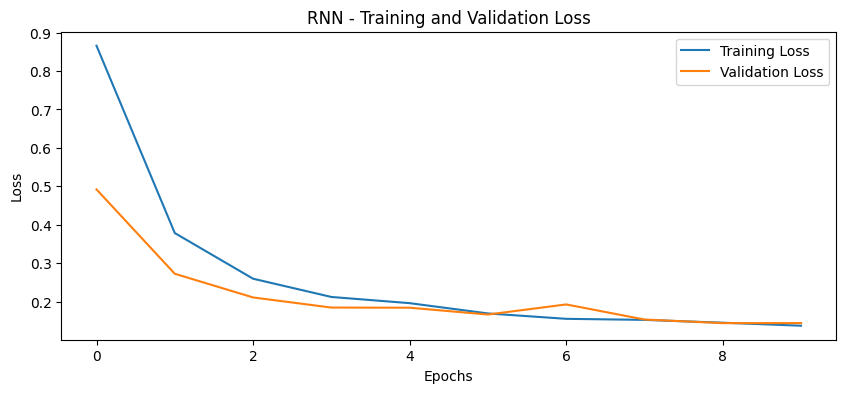

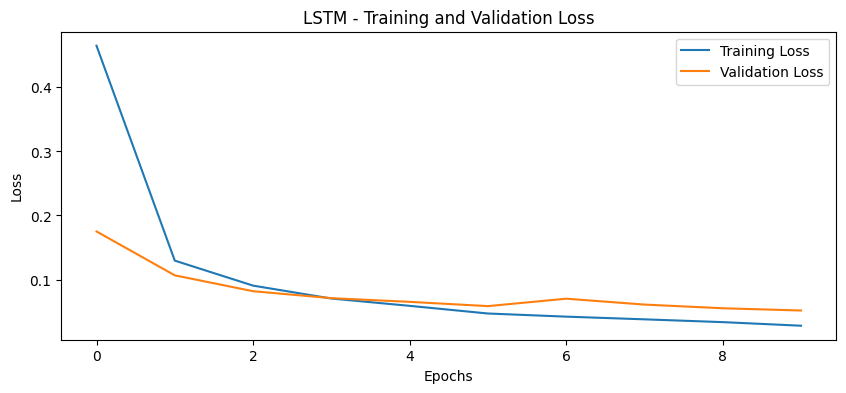

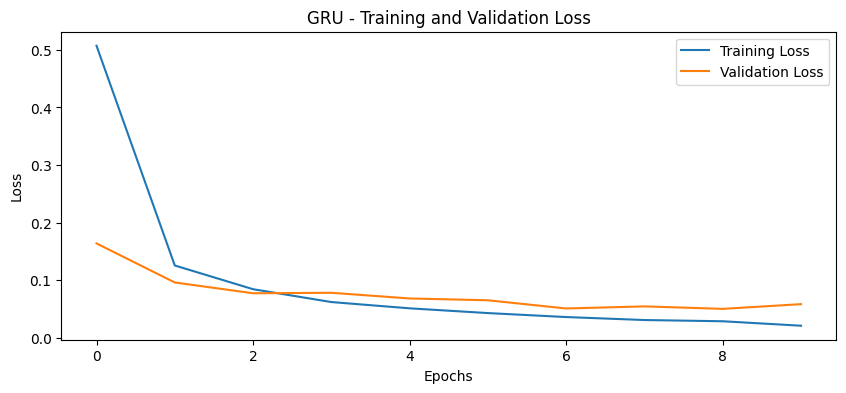

In [55]:
# Plot training and validation progress
for cell_type, (_, _, history) in model_results.items():


    plt.figure(figsize=(10, 4))
    plt.title(f'{cell_type} - Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(history['train_loss'], label='Training Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.show()


## Bidirectional LSTM

Epoch [1/10], Train Loss: 0.4854, Val Loss: 0.1699
Epoch [2/10], Train Loss: 0.1362, Val Loss: 0.1074
Epoch [3/10], Train Loss: 0.0923, Val Loss: 0.0867
Epoch [4/10], Train Loss: 0.0720, Val Loss: 0.0784
Epoch [5/10], Train Loss: 0.0600, Val Loss: 0.0776
Epoch [6/10], Train Loss: 0.0516, Val Loss: 0.0608
Epoch [7/10], Train Loss: 0.0464, Val Loss: 0.0565
Epoch [8/10], Train Loss: 0.0381, Val Loss: 0.0719
Epoch [9/10], Train Loss: 0.0335, Val Loss: 0.0525
Epoch [10/10], Train Loss: 0.0316, Val Loss: 0.0503
Test Accuracy: 98.58%


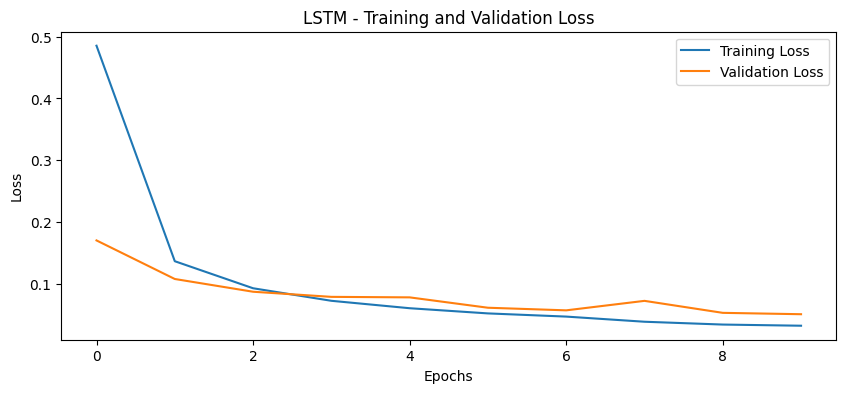

In [54]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# Hyperparameters
input_size = 28
hidden_size = 128
num_layers = 1
num_classes = 10
cell_type = 'LSTM'
bidirectional = True  # Set this to True for bidirectional LSTM
num_epochs = 10
learning_rate = 0.001
batch_size = 64

# Load and preprocess the MNIST dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('./data', train=False, download=True, transform=transform)

# Split the training dataset into training and validation sets
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define the bidirectional LSTM model architecture
class BidirectionalLSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, cell_type='LSTM'):
        super(BidirectionalLSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        if cell_type == 'LSTM':
            self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=bidirectional)
        self.fc = nn.Linear(hidden_size * 2 if bidirectional else hidden_size, num_classes)  # Multiply by 2 for bidirectional

    def forward(self, x):
        out, _ = self.lstm(x, None)
        out = self.fc(out[:, -1, :])
        return out

# Training function with validation
def train(model, train_loader, val_loader, criterion, optimizer, num_epochs):
    history = {'train_loss': [], 'val_loss': []}  # Change dictionary keys to store loss instead of accuracy

    for epoch in range(num_epochs):
        model.train()
        total_train_loss = 0

        for images, labels in train_loader:
            images = images.view(-1, input_size, input_size).to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()

        train_loss = total_train_loss / len(train_loader)
        history['train_loss'].append(train_loss)

        model.eval()
        total_val_loss = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images = images.view(-1, input_size, input_size).to(device)
                labels = labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                total_val_loss += loss.item()

        val_loss = total_val_loss / len(val_loader)
        history['val_loss'].append(val_loss)

        print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

    return history

# Evaluate function
def evaluate(model, test_loader):
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            images = images.view(-1, input_size, input_size).to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

# Create and train the bidirectional LSTM model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = BidirectionalLSTMModel(input_size, hidden_size, num_layers, num_classes, cell_type).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()
history = train(model, train_loader, val_loader, criterion, optimizer, num_epochs)
test_accuracy = evaluate(model, test_loader)

# Print the test accuracy
print(f'Test Accuracy: {test_accuracy:.2f}%')

# Plot training and validation loss figures
plt.figure(figsize=(10, 4))
plt.title(f'{cell_type} - Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(history['train_loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()


## 2. Binary String

2.1 Dataset

In [46]:
import numpy as np

def generate(max_bits, n_samples):
    samples = np.random.randint(2 ** (max_bits - 2), 2 ** (max_bits - 1), size=(n_samples, 2))
    summed_samples = np.sum(samples, axis=1)
    samples_binary_repr = [[np.binary_repr(a, width=max_bits), np.binary_repr(b, width=max_bits)] for a, b in samples]
    summed_binary_repr = [np.binary_repr(c, width=max_bits) for c in summed_samples]
    x_str = np.array([[list(a), list(b)] for a, b in samples_binary_repr])
    y_str = np.array([list(c) for c in summed_binary_repr])
    x_flipped = np.flip(x_str, axis=-1)
    y_flipped = np.flip(y_str, axis=-1)
    x = np.transpose((x_flipped == '1') * 1, axes=(0, 2, 1))
    y = (y_flipped == '1') * 1
    return x, y

bits = 5
n_samples = 100000
x, y = generate(bits, n_samples)

from sklearn.model_selection import train_test_split

# Generate your dataset
x, y = generate(bits, n_samples)

# Split the dataset into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, shuffle=True)



## 2.1 RNN


In [47]:
import tensorflow as tf
from tensorflow.keras import layers

class FullAdderCell(layers.Layer):
    def __init__(self, hidden_units, **kwargs):
        super(FullAdderCell, self).__init__(**kwargs)
        self.units = 1
        self.state_size = 1
        self.hidden_units = hidden_units

    def build(self, input_shape):
        self.hidden_kernel = self.add_weight(
            shape=(input_shape[-1] + self.state_size, self.hidden_units),
            initializer='uniform',
            name='hidden_kernel'
        )
        self.hidden_bias = self.add_weight(
            shape=(1, self.hidden_units),
            initializer='uniform',
            name='hidden_bias'
        )
        self.output_kernel = self.add_weight(
            shape=(self.hidden_units, self.units + self.state_size),
            initializer='uniform',
            name='output_kernel'
        )
        self.output_bias = self.add_weight(
            shape=(1, self.units + self.state_size),
            initializer='uniform',
            name='output_bias'
        )
        self.built = True

    def call(self, inputs, states):
        x = tf.concat([inputs, states[0]], axis=-1)
        h = tf.keras.activations.tanh(tf.matmul(x, self.hidden_kernel) + self.hidden_bias)
        o_s = tf.keras.activations.sigmoid(tf.matmul(h, self.output_kernel) + self.output_bias)
        output = o_s[:, :self.units]
        state = o_s[:, self.units:]
        return output, [state]


2.2.1 Cross Entropy

In [48]:
model1 = tf.keras.Sequential(name='full_adder')
model1.add(layers.RNN(FullAdderCell(5), return_sequences=True, input_shape=(None, 2)))
model1.summary()

model1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model1.fit(x_train, y_train, batch_size=32, epochs=5)


Model: "full_adder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rnn (RNN)                   (None, None, 1)           32        
                                                                 
Total params: 32 (128.00 Byte)
Trainable params: 32 (128.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/5
2813/2813 [==============================] - 22s 7ms/step - loss: 0.6113 - accuracy: 0.7072
Epoch 2/5
2813/2813 [==============================] - 17s 6ms/step - loss: 0.3151 - accuracy: 0.8549
Epoch 3/5
2813/2813 [==============================] - 12s 4ms/step - loss: 0.0169 - accuracy: 1.0000
Epoch 4/5
2813/2813 [==============================] - 13s 4ms/step - loss: 0.0019 - accuracy: 1.0000
Epoch 5/5
2813/2813 [==============================] - 14s 5ms/step - loss: 4.3087e-04 - accuracy: 1.0000


In [49]:
scores = model1.evaluate(x_test, y_test, verbose=2)


313/313 - 1s - loss: 1.9966e-04 - accuracy: 1.0000 - 786ms/epoch - 3ms/step


2.2.2 MSE

In [56]:
model = tf.keras.Sequential(name='full_adder1')
model.add(layers.RNN(FullAdderCell(5), return_sequences=True, input_shape=(None, 2)))
model.summary()

model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
history = model.fit(x_train, y_train, batch_size=32, epochs=5)
scores = model.evaluate(x_test, y_test, verbose=2)


Model: "full_adder1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rnn_4 (RNN)                 (None, None, 1)           32        
                                                                 
Total params: 32 (128.00 Byte)
Trainable params: 32 (128.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/5
2813/2813 [==============================] - 14s 5ms/step - loss: 0.2324 - accuracy: 0.5889
Epoch 2/5
2813/2813 [==============================] - 13s 4ms/step - loss: 0.0468 - accuracy: 0.9548
Epoch 3/5
2813/2813 [==============================] - 13s 4ms/step - loss: 6.2746e-04 - accuracy: 1.0000
Epoch 4/5
2813/2813 [==============================] - 13s 5ms/step - loss: 1.0072e-04 - accuracy: 1.0000
Epoch 5/5
2813/2813 [==============================] - 13s 5ms/step - loss: 2.1534e-05 - accuracy: 1.0000
313/313 - 1s - loss: 9.91

Test loss: 9.919130206981208e-06
Test accuracy: 1.0
313/313 - 1s - loss: 7.8013e-07 - accuracy: 1.0000 - 780ms/epoch - 2ms/step
313/313 - 1s - loss: 7.8232e-07 - accuracy: 1.0000 - 552ms/epoch - 2ms/step
313/313 - 1s - loss: 7.9347e-07 - accuracy: 1.0000 - 571ms/epoch - 2ms/step
313/313 - 1s - loss: 8.0477e-07 - accuracy: 1.0000 - 581ms/epoch - 2ms/step
313/313 - 1s - loss: 8.1371e-07 - accuracy: 1.0000 - 591ms/epoch - 2ms/step
313/313 - 1s - loss: 8.2041e-07 - accuracy: 1.0000 - 597ms/epoch - 2ms/step
313/313 - 1s - loss: 8.2765e-07 - accuracy: 1.0000 - 630ms/epoch - 2ms/step
313/313 - 1s - loss: 8.3351e-07 - accuracy: 1.0000 - 945ms/epoch - 3ms/step
313/313 - 1s - loss: 8.3769e-07 - accuracy: 1.0000 - 669ms/epoch - 2ms/step
313/313 - 1s - loss: 8.3976e-07 - accuracy: 1.0000 - 727ms/epoch - 2ms/step
313/313 - 1s - loss: 8.4434e-07 - accuracy: 1.0000 - 768ms/epoch - 2ms/step
313/313 - 1s - loss: 8.4639e-07 - accuracy: 1.0000 - 707ms/epoch - 2ms/step
313/313 - 1s - loss: 8.4813e-07 - ac

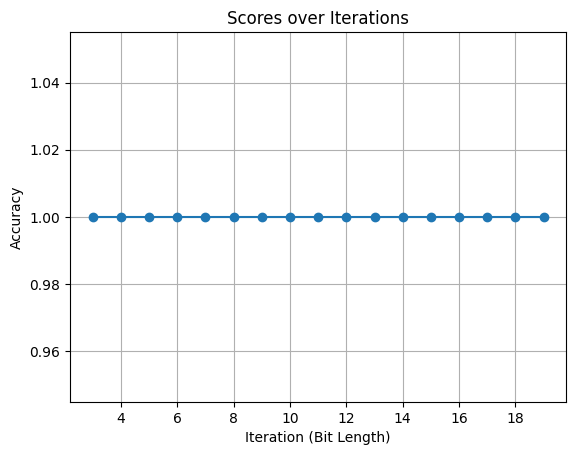

In [58]:
# Print scores
print("Test loss:", scores[0])
print("Test accuracy:", scores[1])

# Experiment with different bit lengths
scores_per_iteration = []
for bits in range(3, 20):
    x_test, y_test = generate(bits, 10000)
    score = model.evaluate(x_test, y_test, verbose=2)
    scores_per_iteration.append(score[1])

# Plot accuracy over iterations (bit lengths)
plt.figure()
plt.plot(range(3, 20), scores_per_iteration, marker='o', linestyle='-')
plt.title('Scores over Iterations')
plt.xlabel('Iteration (Bit Length)')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()


### CrossEntropy has a better accuracy as compared to MSE.

Epoch 1/5
2813/2813 [==============================] - 20s 6ms/step - loss: 0.4007 - accuracy: 0.8871
Epoch 2/5
2813/2813 [==============================] - 23s 8ms/step - loss: 0.2331 - accuracy: 0.9162
Epoch 3/5
2813/2813 [==============================] - 10s 4ms/step - loss: 0.1257 - accuracy: 0.9164
Epoch 4/5
2813/2813 [==============================] - 13s 5ms/step - loss: 0.1182 - accuracy: 0.9169
Epoch 5/5
2813/2813 [==============================] - 10s 3ms/step - loss: 0.1167 - accuracy: 0.9160
3125/3125 - 6s - loss: 0.1164 - accuracy: 0.9163 - 6s/epoch - 2ms/step
3125/3125 - 9s - loss: 0.6872 - accuracy: 0.8752 - 9s/epoch - 3ms/step
3125/3125 - 9s - loss: 0.9828 - accuracy: 0.8318 - 9s/epoch - 3ms/step
3125/3125 - 9s - loss: 1.2179 - accuracy: 0.7981 - 9s/epoch - 3ms/step
3125/3125 - 11s - loss: 1.3776 - accuracy: 0.7729 - 11s/epoch - 4ms/step
3125/3125 - 11s - loss: 1.5095 - accuracy: 0.7520 - 11s/epoch - 3ms/step
3125/3125 - 9s - loss: 1.6232 - accuracy: 0.7336 - 9s/epoch 

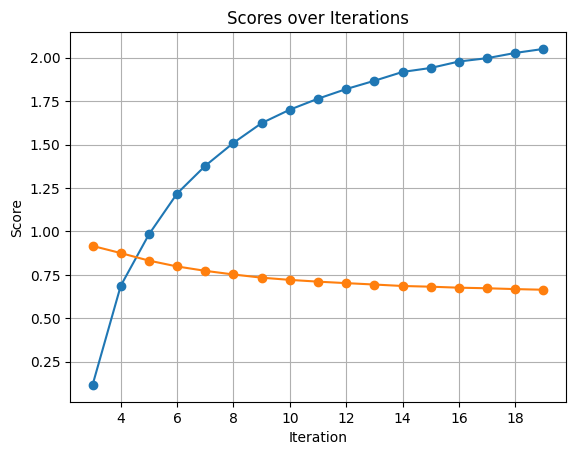

In [51]:
x,y = generate(3,n_samples)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1,shuffle=True)
model1 = tf.keras.Sequential(name='full_adder')
model1.add(layers.RNN(FullAdderCell(5), return_sequences=True,input_shape=(None, 2)))
model1.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])
history = model1.fit(x_train, y_train, batch_size=32, epochs=5)

scores = []
for i in range(3,20):
    x_test, y_test = generate(i,100000)
    score = model1.evaluate(x_test, y_test, verbose=2)
    scores.append(score)
plt.figure()
plt.plot(range(3, 20), scores, marker='o', linestyle='-')
plt.title('Scores over Iterations')
plt.xlabel('Iteration')
plt.ylabel('Score')
plt.grid(True)
plt.show()

Model: "full_adder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rnn_3 (RNN)                 (None, None, 1)           32        
                                                                 
Total params: 32 (128.00 Byte)
Trainable params: 32 (128.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/5
2813/2813 [==============================] - 15s 5ms/step - loss: 0.6611 - accuracy: 0.5912
Epoch 2/5
2813/2813 [==============================] - 14s 5ms/step - loss: 0.2459 - accuracy: 0.8791
Epoch 3/5
2813/2813 [==============================] - 13s 5ms/step - loss: 0.0069 - accuracy: 1.0000
Epoch 4/5
2813/2813 [==============================] - 14s 5ms/step - loss: 0.0013 - accuracy: 1.0000
Epoch 5/5
2813/2813 [==============================] - 13s 5ms/step - loss: 2.9233e-04 - accuracy: 1.0000
313/313 - 1s - loss: 1.0019e-04 - 

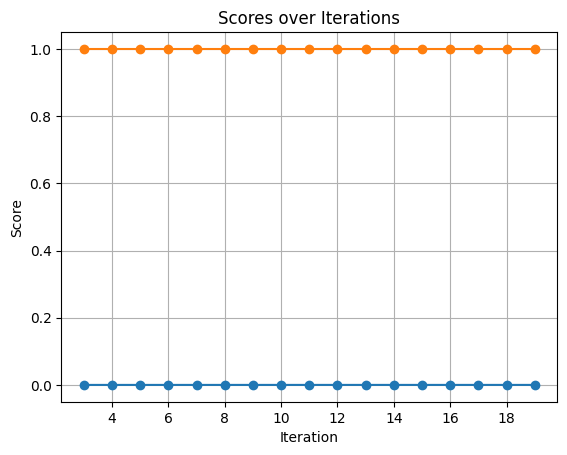

In [52]:
x,y = generate(8,100000)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1,shuffle=True)
model1 = tf.keras.Sequential(name='full_adder')
model1.add(layers.RNN(FullAdderCell(5), return_sequences=True,input_shape=(None, 2)))
model1.summary()
model1.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])
history = model1.fit(x_train, y_train, batch_size=32, epochs=5)

scores = []
for i in range(3,20):
    x_test, y_test = generate(i,10000)
    score = model1.evaluate(x_test, y_test, verbose=2)
    scores.append(score)
plt.figure()
plt.plot(range(3, 20), scores, marker='o', linestyle='-')
plt.title('Scores over Iterations')
plt.xlabel('Iteration')
plt.ylabel('Score')
plt.grid(True)
plt.show()